# State of the Union analytics

In [1]:
%load_ext lab_black

In [2]:
import pandas as pd
import glob
import altair as alt
import numpy as np

In [3]:
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 1500

----

## List of presidents

In [4]:
pres_src = pd.read_html(
    "https://history.house.gov/Institution/Presidents-Coinciding/Presidents-Coinciding/"
)[0]

#### Slim down the number of columns and clean up strings

In [5]:
pres_df = pres_src[~pres_src["No."].isnull()][["No.", "President"]]

In [6]:
pres_df.columns = pres_df.columns.str.lower().str.replace(".", "", regex=False)
pres_df["president"] = pres_df["president"].str.strip()
pres_df["president"] = (
    pres_df["president"]
    .str.replace("\d+", "", regex=True)
    .str.replace("Van Buren", "van Buren", regex=False)
    .str.replace("James K. Polk", "James Polk", regex=False)
    .str.replace("Richard M. Nixon", "Richard Nixon", regex=False)
    .str.replace("George Bush", "George H.W. Bush", regex=False)
    .str.replace("Barack H. Obama", "Barack Obama", regex=False)
    .str.replace("Joseph R. Biden, Jr.", "Joseph R. Biden", regex=False)
    .str.replace("Herbert C. Hoover", "Herbert Hoover", regex=False)
    .str.replace("Warren G. Harding", "Warren Harding", regex=False)
    .str.replace("James Earl Carter", "Jimmy Carter", regex=False)
)
pres_df["no"] = pres_df["no"].astype(str).str.replace(".0", "", regex=False).astype(int)

#### What's left?

In [7]:
pres_df.head()

,no,president
0,1,George Washington
1,2,John Adams
2,3,Thomas Jefferson
4,4,James Madison
6,5,James Monroe


---

## SOTU analytics

In [8]:
#### http://stateoftheunion.onetwothree.net/data/documentsData.json

#### Read data

In [9]:
src = pd.read_json("data/raw/documentsData.json").T.reset_index()

#### Dates

In [10]:
src["date"] = pd.to_datetime(src["index"]).copy()
src["year"] = src["date"].dt.year

#### Prepare president column for join

In [11]:
src["author"] = src["author"].str.strip()
src.rename(columns={"author": "president"}, inplace=True)

#### Top words

In [12]:
words = []

for r in range(0, 234):
    words.append(
        pd.json_normalize(src["wordList"][r])
        .sort_values("freq", ascending=False)
        .reset_index(drop=True)
        .iloc[0, 0]
    )

#### Slim down the columns we need

In [13]:
df = src[
    [
        "date",
        "year",
        "president",
        "maxFreq",
        "numberOfSentences",
        "numberOfWords",
        "numberOfSyllables",
        "fleschKincaid",
        "wordList",
    ]
]

#### Merge the presidents list and the analytics

In [14]:
merge = pd.merge(df, pres_df, on="president", how="inner").drop_duplicates(
    subset=["date", "president"]
)

In [15]:
merge.head()

,date,year,president,maxFreq,numberOfSentences,numberOfWords,numberOfSyllables,fleschKincaid,wordList,no
0,1790-01-08,1790,George Washington,3,24,1085,1869,22.367702,"[{'word': 'aggressors', 'position': 0.36129034...",1
1,1790-12-08,1790,George Washington,3,40,1403,2288,17.332584,"[{'word': '3,000,000', 'position': 0.13114753,...",1
2,1791-10-25,1791,George Washington,7,60,2304,3937,19.549458,"[{'word': '2,500,000', 'position': 0.59071183,...",1
3,1792-11-06,1792,George Washington,8,61,2099,3492,17.460896,"[{'word': '4.5%', 'position': 0.8027632, 'freq...",1
4,1793-12-03,1793,George Washington,24,56,1965,3233,17.509274,"[{'word': '3%', 'position': 0.8122136999999999...",1


#### Top words used by all presidents

In [16]:
words = []

for r, p, d in zip(merge.index, merge.president, merge.date):
    words.append(pd.json_normalize(merge["wordList"][r]).assign(name=p, date=d))

In [17]:
words_df = pd.concat(words)

In [18]:
top_words = words_df.loc[words_df.groupby("date")["freq"].idxmax()]

In [19]:
len(top_words)

55225

In [20]:
top_words_freq = top_words.groupby(["date", "name"])["freq"].max().reset_index()

In [21]:
top_words_years = (
    pd.merge(top_words, top_words_freq, on=["name", "date", "freq"])
    .drop_duplicates(subset=["name", "date", "freq"])
    .sort_values("date")
)

In [22]:
final = pd.merge(merge, top_words_years, on=["date"])

In [23]:
final.columns

Index(['date', 'year', 'president', 'maxFreq', 'numberOfSentences',
       'numberOfWords', 'numberOfSyllables', 'fleschKincaid', 'wordList', 'no',
       'word', 'position', 'freq', 'corpFreqAsPercent', 'freqAsPercent',
       'freqAsPercentDiff', 'LLS', 'L1LLS', 'S', 'alpha', 'df', 'tfIDF',
       'name'],
      dtype='object')

In [24]:
final_df = final[
    [
        "date",
        "year",
        "president",
        "no",
        "maxFreq",
        "numberOfSentences",
        "numberOfWords",
        "numberOfSyllables",
        "fleschKincaid",
        "word",
    ]
].copy()

In [25]:
final_df["word"] = final_df["word"].str.lower()

---

## Aggregate

#### Words, sentences and syllables — by president

In [26]:
by_pres = (
    final_df.groupby(["no", "president"])
    .agg(
        {
            "numberOfSentences": "mean",
            "numberOfWords": "mean",
            "numberOfSyllables": "mean",
            "fleschKincaid": "mean",
        }
    )
    .round()
    .reset_index()
    .sort_values("no")
)

In [27]:
by_pres.head()

,no,president,numberOfSentences,numberOfWords,numberOfSyllables,fleschKincaid
0,1,George Washington,57.0,2078.0,3486.0,19.0
1,2,John Adams,48.0,1789.0,2998.0,19.0
2,3,Thomas Jefferson,67.0,2582.0,4200.0,19.0
3,4,James Madison,60.0,2706.0,4567.0,22.0
4,5,James Monroe,146.0,5279.0,8560.0,18.0


In [28]:
by_pres.tail()

,no,president,numberOfSentences,numberOfWords,numberOfSyllables,fleschKincaid
38,42,William J. Clinton,376.0,7362.0,11047.0,10.0
39,43,George W. Bush,262.0,4824.0,7563.0,10.0
40,44,Barack Obama,360.0,6518.0,9811.0,9.0
41,45,Donald J. Trump,312.0,5306.0,8335.0,10.0
42,46,Joseph R. Biden,460.0,6036.0,9095.0,7.0


---

## Chart sketches

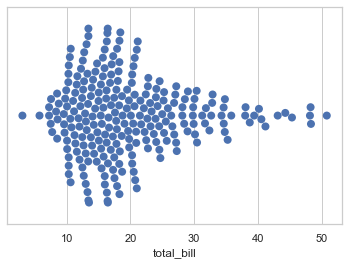

In [46]:
import seaborn as sns

sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.swarmplot(x=tips["total_bill"], size=8)

In [29]:
alt.Chart(by_pres).mark_bar().encode(
    y=alt.Y("president", sort=alt.EncodingSortField(field="no", order="ascending")),
    x="fleschKincaid",
)

alt.Chart(...)

#### Syllables, by year

In [30]:
alt.Chart(final_df).mark_area().encode(x="date", y="numberOfSyllables").properties(
    width=600
)

alt.Chart(...)

In [31]:
alt.Chart(final_df).mark_line().encode(
    x="year:O",
    y="fleschKincaid",
).properties(width=650)

alt.Chart(...)

In [32]:
words_counts = pd.read_csv("data/raw/words_counts.txt", sep="	")

In [33]:
selected_words = [
    "America",
    "government",
    "states",
    "strong",
    "terrorism",
    "people",
    "war",
    "jobs",
    "slavery",
    "space",
    "wages",
    "fight",
    "peace",
    "bipartisan",
    "together",
    "division",
    "united",
    "citizens",
    "military",
    "constitution",
]

In [34]:
selected_words_df = words_counts[words_counts["word"].isin(selected_words)]

In [35]:
selected_words_export = (
    selected_words_df[["word", "corpus"]]
    .sort_values("corpus", ascending=False)
    .reset_index(drop=True)
)

In [36]:
selected_words_export["word"] = selected_words_export["word"].str.title()

#### Exports

In [37]:
selected_words_export.to_csv("data/processed/selected_words_counts.csv", index=False)

In [38]:
final_df.to_csv("data/processed/sotu_analytics.csv", index=False)

In [39]:
final_df[["date", "president", "word"]].to_csv(
    "data/processed/sotu_analytics_top_word_each_year.csv", index=False
)